# Trauma Transfer Learning Experiment

This notebook compares baseline survival models and a transfer learning approach using Indian and Jordan trauma datasets.

In [1]:
!pip -q install pandas numpy matplotlib seaborn scikit-learn lifelines scikit-survival

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

sns.set(style='whitegrid')


## Load datasets

In [3]:
india_file = 'trauma_india_brain_injury.csv'
jordan_file = 'traumatic_brain_injury.csv'

cols_india = ['age','sex','sbp_1','hr_1','rr_1','gcs_t_1','doa','toa','dodd','todd','died']
india = pd.read_csv(india_file, usecols=cols_india)

cols_jordan = ['Gender','age of diagnosis','ER-HR','ER-RR','ER-systolic BP','GCS in ER','length of stay in the hospital (in days)','outcome']
jordan = pd.read_csv(jordan_file, usecols=cols_jordan)


In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Select only numeric columns for imputation
jordan_numeric = jordan.select_dtypes(include=[np.number])

# Perform iterative imputation
imputer = IterativeImputer(random_state=0)
jordan_imputed_array = imputer.fit_transform(jordan_numeric)

# Replace numeric columns in jordan with imputed values
jordan[jordan_numeric.columns] = jordan_imputed_array

print(jordan.head())

   Gender  age of diagnosis  GCS in ER        ER-HR      ER-RR ER-systolic BP  \
0  Female               6.0       15.0  tachycardia  tachypnea         normal   
1    Male               7.0       15.0       normal     normal         normal   
2    Male              13.0        3.0       normal     normal         normal   
3    Male               9.0       13.0       normal     normal         normal   
4    Male               1.5       15.0       normal     normal         normal   

   length of stay in the hospital (in days)   outcome  
0                                       5.0  survival  
1                                       7.0  survival  
2                                       7.0  survival  
3                                      28.0  survival  
4                                       3.0  survival  


## Feature engineering

In [5]:
def parse_datetime(date_col, time_col):
    dt = pd.to_datetime(date_col + ' ' + time_col, errors='coerce')
    return dt

india['admit_time'] = parse_datetime(india['doa'], india['toa'])
india['discharge_time'] = parse_datetime(india['dodd'], india['todd'])
india['los'] = (india['discharge_time'] - india['admit_time']).dt.total_seconds() / 3600
india['los'] = india['los'].fillna(0)
india['event'] = (india['died'] == 'Yes').astype(int)

jordan['los'] = pd.to_numeric(jordan['length of stay in the hospital (in days)'], errors='coerce')
jordan['event'] = (jordan['outcome'] == 'died').astype(int)

india['sex'] = india['sex'].map({'Male':1,'Female':0})
jordan['Gender'] = jordan['Gender'].map({'Male':1,'Female':0})

features_india = india[['age','sex','sbp_1','hr_1','rr_1','gcs_t_1']].copy()
features_jordan = jordan[['age of diagnosis','Gender','ER-HR','ER-RR','ER-systolic BP','GCS in ER']].copy()
features_jordan.columns = ['age','sex','hr','rr','sbp','gcs']
features_india.columns = ['age','sex','sbp','hr','rr','gcs']


C:\Users\shrin\AppData\Local\Temp\ipykernel_46604\3413719261.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(date_col + ' ' + time_col, errors='coerce')
C:\Users\shrin\AppData\Local\Temp\ipykernel_46604\3413719261.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(date_col + ' ' + time_col, errors='coerce')


## Exploratory analysis

India rows: 7978
Jordan rows: 112
Indian LOS summary (hours):
count    7978.000000
mean      173.574866
std       338.993580
min      -240.000000
25%        44.166667
50%       109.833333
75%       194.333333
max      8936.333333
Name: los, dtype: float64
Jordan LOS summary (days):
count    112.000000
mean      11.964021
std       16.145693
min        1.000000
25%        4.000000
50%        7.000000
75%       12.000000
max      126.000000
Name: los, dtype: float64


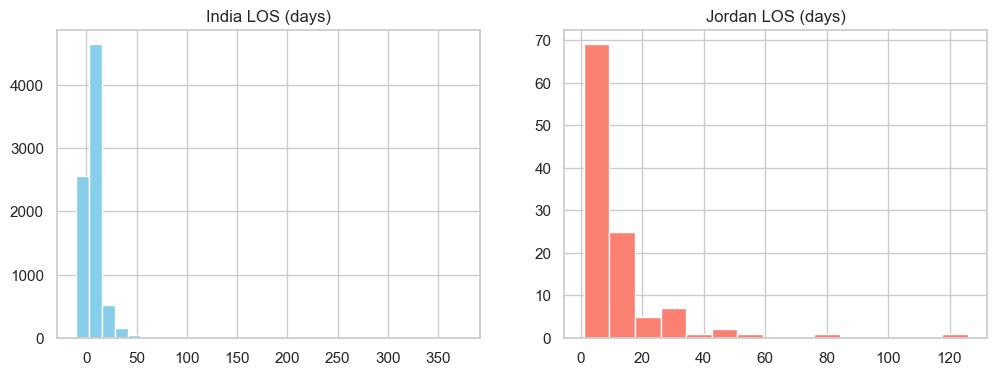

In [6]:
print('India rows:', len(india))
print('Jordan rows:', len(jordan))

print('Indian LOS summary (hours):')
print(india['los'].describe())
print('Jordan LOS summary (days):')
print(jordan['los'].describe())

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(india['los']/24, bins=30, color='skyblue')
axes[0].set_title('India LOS (days)')
axes[1].hist(jordan['los'], bins=15, color='salmon')
axes[1].set_title('Jordan LOS (days)')
plt.show()


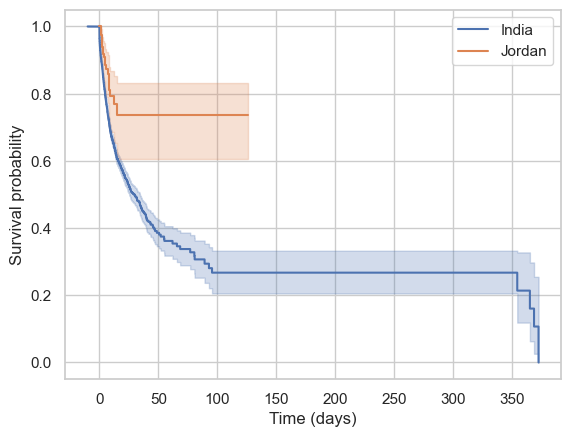

In [7]:
kmf = KaplanMeierFitter()
kmf.fit(durations=india['los']/24, event_observed=india['event'], label='India')
ax = kmf.plot()
kmf.fit(durations=jordan['los'], event_observed=jordan['event'], label='Jordan')
kmf.plot(ax=ax)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Survival probability')
plt.show()


## Baseline Cox model on Jordan data

In [8]:
baseline_data = features_jordan.copy()
baseline_data['duration'] = jordan['los']
baseline_data['event'] = jordan['event']

cph = CoxPHFitter()
cph.fit(baseline_data, duration_col='duration', event_col='event')
print(cph.summary)
print('Baseline C-index:', concordance_index(baseline_data['duration'], -cph.predict_partial_hazard(baseline_data), baseline_data['event']))


ValueError: could not convert string to float: 'tachycardia'

## Transfer learning with gradient boosting

In [ ]:
X_india = features_india.fillna(features_india.median())
y_india = np.array([(bool(e), t) for e,t in zip(india['event'], india['los']/24)], dtype=[('event', bool), ('time', float)])

X_jordan = features_jordan.fillna(features_jordan.median())
y_jordan = np.array([(bool(e), t) for e,t in zip(jordan['event'], jordan['los'])], dtype=[('event', bool), ('time', float)])

# baseline without transfer
gb_baseline = GradientBoostingSurvivalAnalysis(random_state=0)
gb_baseline.fit(X_jordan, y_jordan)
base_cindex = gb_baseline.score(X_jordan, y_jordan)
print('Baseline gradient boosting C-index:', base_cindex)

# pretrain on India then fine-tune on Jordan
gb_transfer = GradientBoostingSurvivalAnalysis(random_state=0, n_estimators=100, warm_start=True)
gb_transfer.fit(X_india, y_india)
# add more estimators for fine-tuning
gb_transfer.set_params(n_estimators=150)
gb_transfer.fit(X_jordan, y_jordan)
transfer_cindex = gb_transfer.score(X_jordan, y_jordan)
print('Transfer learning C-index:', transfer_cindex)


In [ ]:
plt.step(*gb_transfer.predict_survival_function(X_jordan.iloc[:5]).T)
plt.xlabel('Time (days)')
plt.ylabel('Survival probability')
plt.title('Example predicted curves (Jordan)')
plt.show()
